This project aims to explore the distribution of selected keywords in historical corpuses to provide insights in terms of their temporal dynamic with respect to their contextual meaning.
Consider the popular Harry potter movie whose dataset is available in Harry Potter Dataset | Kaggle, indicating the content of the three movie distinguishing the script of each character of the movies. You may also find in Kaggle some code for data handling and visualization.


# Part 1
### 1. Write a script that calculates the length of total script of each character and draws the histogram showing the length of script of each character.

            Character  Script Length
0               Harry          26685
1            Hermione          14317
2                 Ron          14135
3              Hagrid          13511
4          Dumbledore          11489
5               Lupin           7613
6          Mcgonagall           6906
7               Snape           5481
8   Gilderoy Lockhart           4111
9          Tom Riddle           3390
10              Draco           3102
11      Lucius Malfoy           2553
12              Dobby           2523
13             Sirius           2490
14              Fudge           2309
15       Mrs. Weasley           2144
16       Uncle Vernon           1892
17          Trelawney           1513
18              Filch           1439
19            Petunia           1413


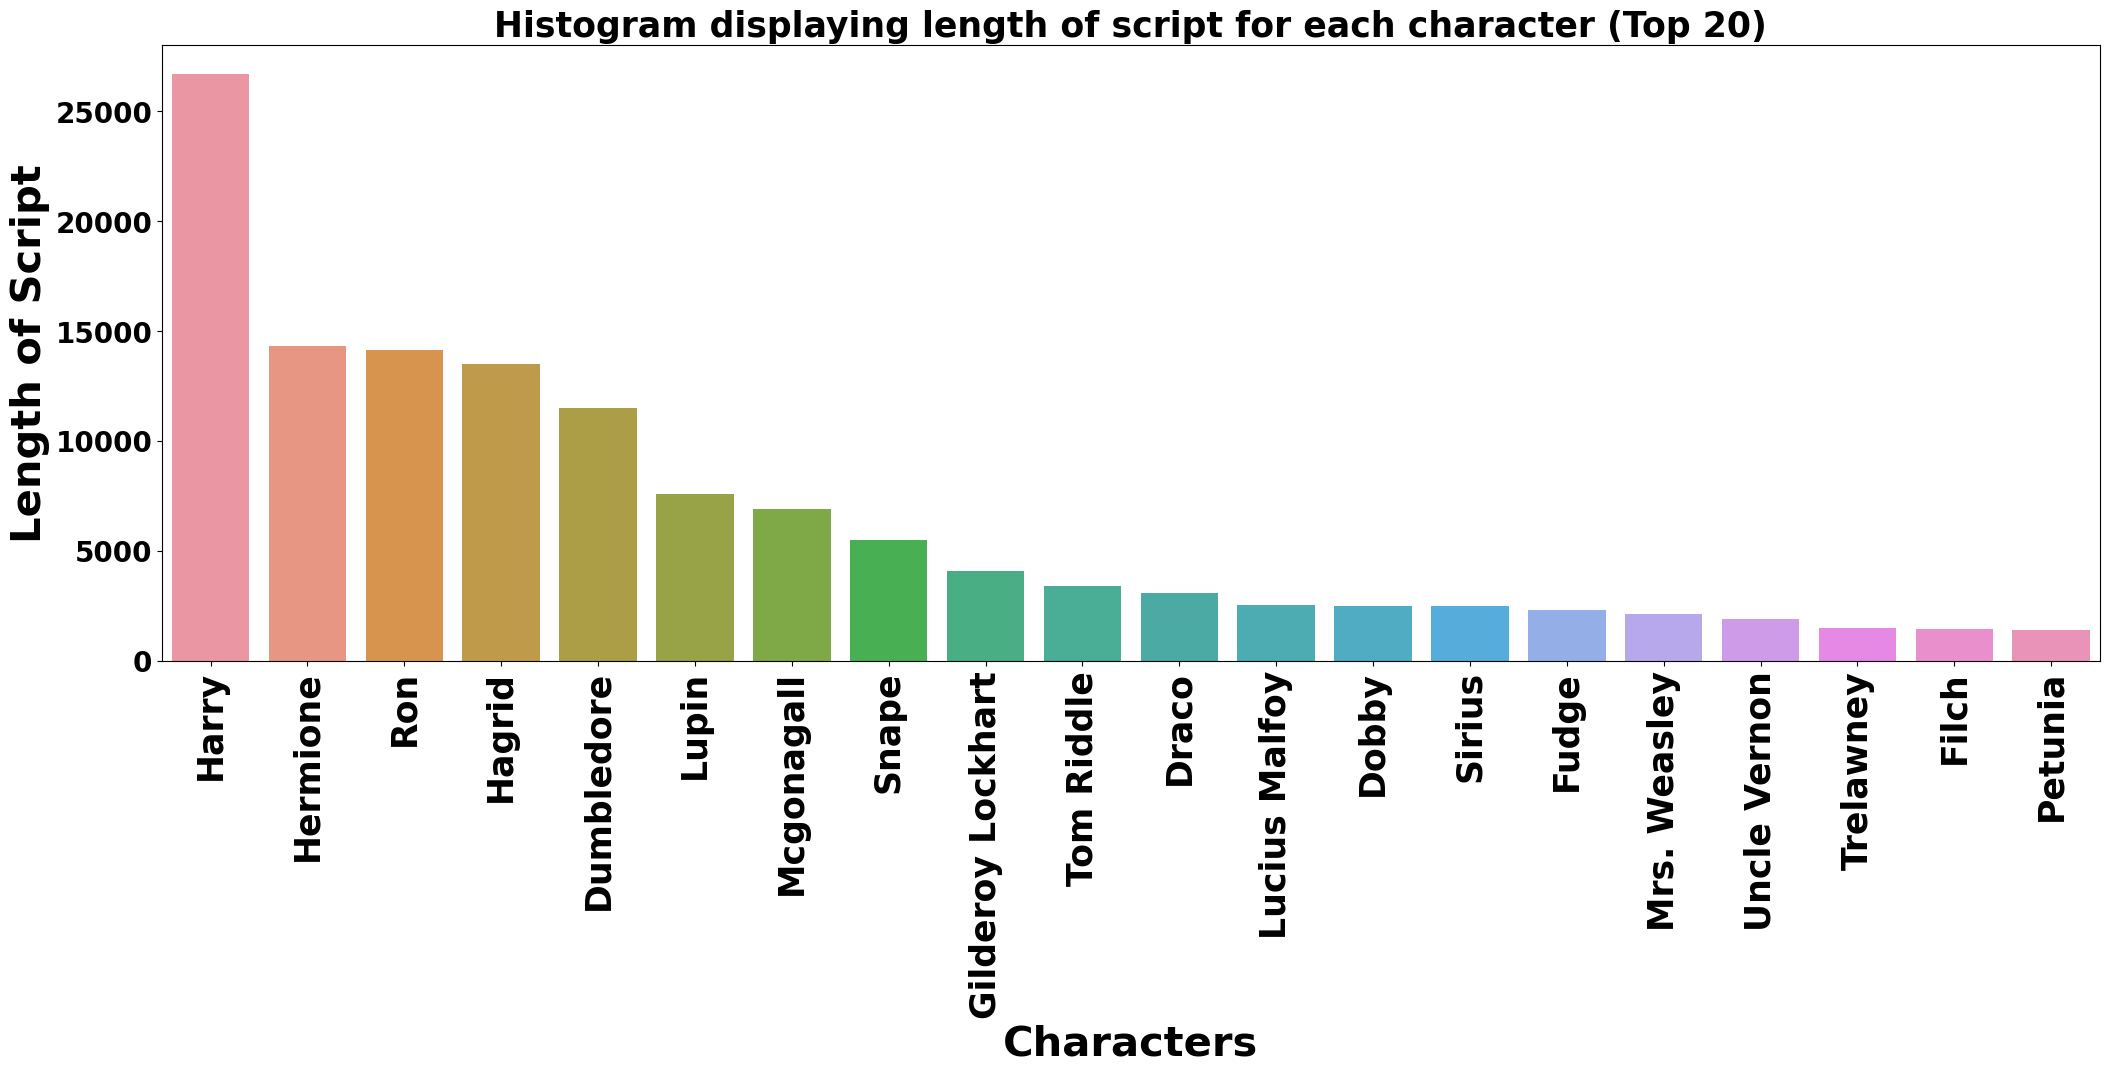

In [1]:
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
from gensim import corpora, models
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import pandas as pd
from collections import Counter

pd.set_option('display.max_columns', None)

files = ["Harry_Potter_1.csv","Harry_Potter_2.csv","Harry_Potter_3.csv"]

li = []

for filename in files:
    df = pd.read_csv(filename, sep = ";")
    df.columns = df.columns.str.title()
    li.append(df)

df = pd.concat(li, axis=0, ignore_index=True)

df["Character"] = df["Character"].apply(lambda x: x.strip().title()) 
df["Script Length"] = df["Sentence"].apply(lambda x: len(x))

# Group the data by character name and calculate the total length of script for each character
characters = df.groupby("Character",sort=True).sum().sort_values(["Script Length"],ascending=False).reset_index()
no_of_characters = 20
characters = characters.iloc[:no_of_characters,:]
print(characters)

# Plot the histogram of script lengths
plt.figure(figsize=(25,8))
sns.barplot(x = characters["Character"],y=characters["Script Length"])
plt.ylabel("Length of Script",fontsize=30, weight='bold')
plt.xlabel("Characters",fontsize=30, weight='bold')
plt.xticks(rotation = 90, fontsize=25,weight='bold')
plt.yticks(fontsize=20, weight='bold')
plt.title("Histogram displaying length of script for each character (Top {})".format(no_of_characters),fontsize=25, weight='bold')
plt.show()

# Part 2
### 2.	Consider the list of personal pronouns and Bing Liu opinion sentiment available at http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html. Write a script that counts the total number of personal pronouns in each characters’s scripts, and draw histogram. Repeat this process for both positive and negative sentiment word according to Bing Liu lexicon, and draw the corresponding histogram.

######################## Done ###########################


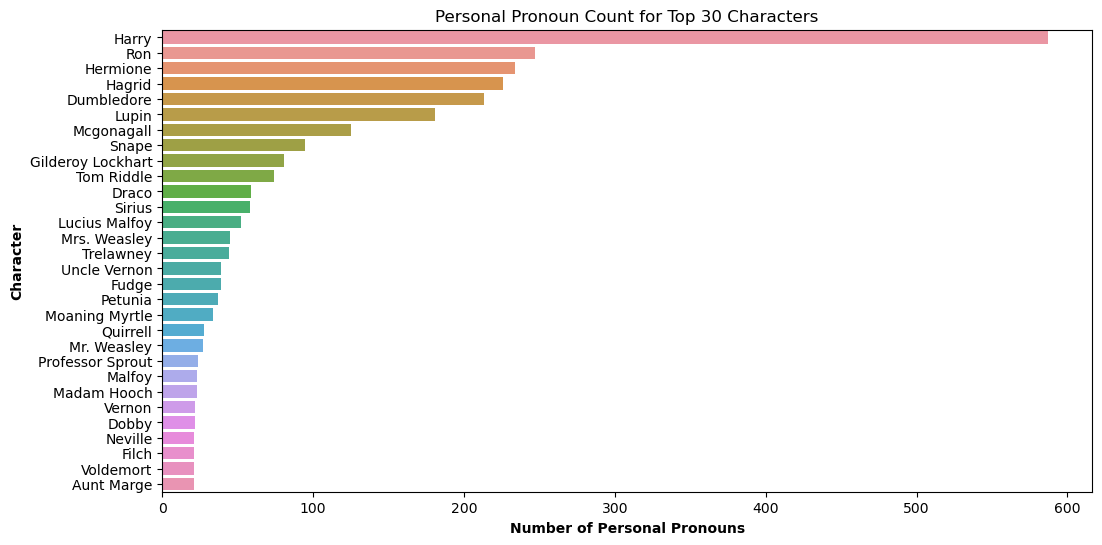

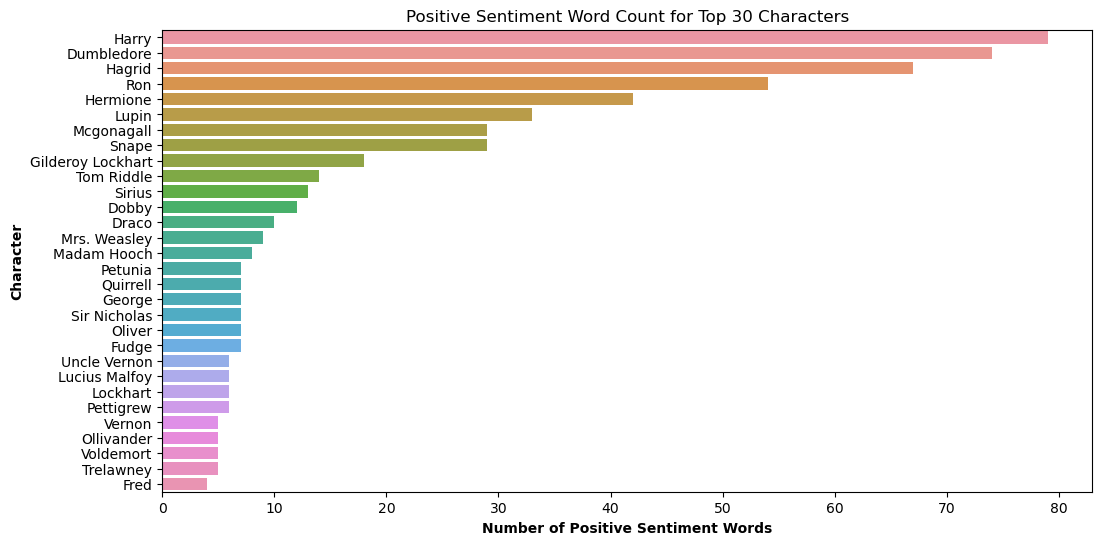

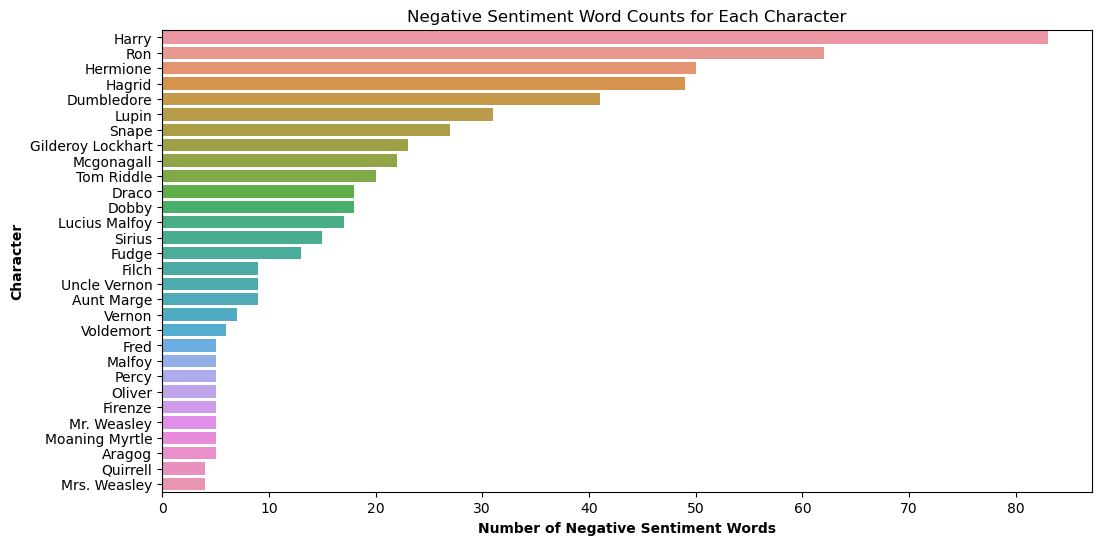

In [2]:
# Load the list of personal pronouns
pronouns = ['i', 'me', 'my', 'mine', 'myself',
            'you', 'your', 'yours', 'yourself',
            'he', 'him', 'his', 'himself',
            'she', 'her', 'hers', 'herself',
            'it', 'its', 'itself',
            'we', 'us', 'our', 'ours', 'ourselves',
            'they', 'them', 'their', 'theirs', 'themselves']

# Load the list of positive and negative sentiment words
positive_words = []
negative_words = []

with open("Bing.csv") as f:
        lines = f.readlines()
for line in lines:
    word = line.split(",")[0]
    if line.split(",")[1].strip() == "positive":
        positive_words.append(word)
    else:
        negative_words.append(word)
print("######################## Done ###########################")

# Count the number of personal pronouns in each character's scripts
pronoun_counts = {}

for character in df["Character"].unique():
    
    character_scripts = df[df["Character"] == character]["Sentence"]
    count = 0
    for script in character_scripts:
        count += len([word for word in script.lower().split() if word in pronouns])
    pronoun_counts[character] = count

pronoun_counts = dict(sorted(pronoun_counts.items(), key=lambda item: item[1],reverse=True))
no_of_characters = 30
# Plot the histogram of personal pronoun counts
plt.figure(figsize=(12,6))
sns.barplot(x = list(pronoun_counts.values())[:no_of_characters], y = list(pronoun_counts.keys())[:no_of_characters],orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Personal Pronouns",weight='bold')
plt.title("Personal Pronoun Count for Top {} Characters".format(no_of_characters))
plt.show()

# Count the number of positive and negative sentiment words in each character's scripts
positive_counts = {}
negative_counts = {}
for character in df["Character"].unique():
    character_scripts = df[df["Character"] == character]["Sentence"]
    positive_count = 0
    negative_count = 0
    for script in character_scripts:
        positive_count += len([word for word in script.lower().split() if word in positive_words])
        negative_count += len([word for word in script.lower().split() if word in negative_words])
    positive_counts[character] = positive_count
    negative_counts[character] = negative_count

# Plot the histograms of positive and negative sentiment word counts

positive_counts = dict(sorted(positive_counts.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(12,6))
sns.barplot(x = list(positive_counts.values())[:no_of_characters], y = list(positive_counts.keys())[:no_of_characters],orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Positive Sentiment Words",weight='bold')
plt.title("Positive Sentiment Word Count for Top {} Characters".format(no_of_characters))
plt.show()

negative_counts = dict(sorted(negative_counts.items(), key=lambda item: item[1],reverse=True))
plt.figure(figsize=(12,6))
sns.barplot(x = list(negative_counts.values())[:no_of_characters], y = list(negative_counts.keys())[:no_of_characters], orient='h')
plt.ylabel("Character",weight='bold')
plt.xlabel("Number of Negative Sentiment Words",weight='bold')
plt.title("Negative Sentiment Word Counts for Each Character")
plt.show()

# Part 3
Consider the corpus of each character (concatenation of all scripts of each character). Perform the LDA for topic modelling with Number of Topics = 5 and Number of Keywords per Topic = 5. Visualize the outcomes of the topic modelling according to the method of your choice in such a way to seek the overlapping among the various characters.

In [29]:
# Define a function to preprocess the text
def preprocess(text):
    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return tokens

# Concatenate the scripts for each character
characters = df["Character"].unique().tolist()
corpus = {}

for character in tqdm(characters):
    flat_list = []
    l = df[df["Character"] == character]["Sentence"].apply(preprocess).tolist()
    for sublist in l:
        for item in sublist:
            flat_list.append(item)
    corpus[character] = flat_list

100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:06<00:00, 17.88it/s]


# Topic Modelling using LDA

In [4]:
import gensim
from gensim import corpora

dictionary = corpora.Dictionary([corpus[character] for character in characters])

# Create a bag-of-words representation of the corpus
bow_corpus = [dictionary.doc2bow(corpus[character]) for character in characters]

# Train the LDA model
num_topics = 5
num_keywords = 5

lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)

# visualize the topics with pyLDAvis
import pyLDAvis
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, dictionary)
pyLDAvis.display(vis)

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [5]:
dictionary = corpora.Dictionary([corpus[character] for character in characters])

# Create a bag-of-words representation of the corpus
#bow_corpus = [dictionary.doc2bow(corpus[character]) for character in characters]
bow_corpus = {character: [dictionary.doc2bow(corpus[character])] for character in characters}
# Train the LDA model
num_topics = 5
num_keywords = 5

lda_models = {}

for name in tqdm(characters):
    lda_model = models.LdaModel(bow_corpus[name], id2word=dictionary, num_topics=num_topics, passes=10, alpha='auto', eta='auto')
    lda_models[name] = lda_model
    

  6%|████▌                                                                             | 6/108 [00:00<00:07, 13.80it/s]E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\ldamodel.py:824: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words
 76%|█████████████████████████████████████████████████████████████▌                   | 82/108 [00:05<00:01, 17.23it/s]E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\gensim\models\ldamodel.py:821: RuntimeWarning: divide by zero encountered in double_scalars
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
100%|████████████████████████████████████████████████████████████████████████████████| 108/108 [00:06<00:00, 16.39it/s]


In [ ]:
character_topics = {}

for char_name, lda_model in tqdm(lda_models.items()):
    for char_name1, lda_model1 in lda_models.items():
        if char_name != char_name1:
            topics = []
            overlapping = []
            for topic_num in range(num_topics):
                top_keywords = [word for word, _ in lda_model.show_topic(topic_num, topn=20)]
                top_keywords1 = [word for word, _ in lda_model1.show_topic(topic_num, topn=20)]
                a_set = set(top_keywords)
                b_set = set(top_keywords1)

                print("----- Topic {} -----".format(topic_num))
                print("Total Number of Common Words between {} & {} characters = {}".format(char_name,char_name1,len(list(a_set.intersection(b_set)))))
                print("######## Common Words ######## \n{}".format(a_set.intersection(b_set)))
                
                num = len(list(a_set.intersection(b_set)))
                den = len(list(a_set) + list(b_set))
                over = (num / den)*100
                print("Overlapping Percentage = {}".format(over))
                print("#####################################################")
                print("")
                topics.append(str(topic_num))
                overlapping.append(over)
                
            plt.figure(figsize=(6,3))
            
            df1 = pd.DataFrame({"Topic":topics,"Overlapping":overlapping})
            
            sns.barplot(data = df1,y="Overlapping",x="Topic",)
            plt.xlabel("Topic Number")
            plt.ylabel("% Overlap b/w {} & {}".format(char_name,char_name1),fontsize=8)
            plt.show()
            

#overlapping_keywords = set.intersection(*[set(topic) for topics in character_topics.values() for topic in topics])
#print("Overlapping keywords:", overlapping_keywords)

# Topic Modelling using NMF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

character_scripts = df.groupby('Character')['Sentence'].apply(lambda x: ' '.join(x)).reset_index()

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Fit and transform the vectorizer on the concatenated scripts
tfidf = tfidf_vectorizer.fit_transform(corpus)

# Create an NMF object with 5 topics
nmf_model = NMF(n_components=5, random_state=42)

# Fit the NMF model on the TF-IDF matrix
nmf_model.fit(tfidf)

# Get the top 5 keywords for each topic
num_top_words = 5
feature_names = tfidf_vectorizer.get_feature_names_out()
topic_keywords = []
for topic_idx, topic in enumerate(nmf_model.components_):
    top_keywords = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    topic_keywords.append(top_keywords)

# Print the top 5 keywords for each topic
for i, topic in enumerate(topic_keywords):
    print(f"Topic {i}: {' '.join(topic)}")

Topic 0: ron harry fred george hermione
Topic 1: tom lockhart madam jordan boy
Topic 2: shrunken head weasley mr jordan
Topic 3: boy petunia aunt dudley jordan
Topic 4: madam petunia aunt dudley vernon


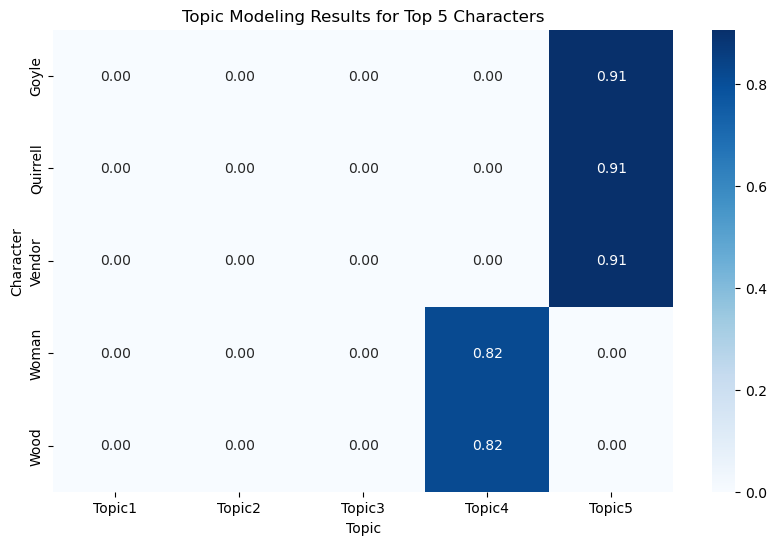

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Get the topic distribution for each character
nmf_features = nmf_model.transform(tfidf)
character_topics = pd.DataFrame(data=nmf_features, columns=[f"Topic{i}" for i in range(1,6)])
character_topics['Character'] = character_scripts['Character']

# Get the top 5 characters with the most common words
top_characters = character_topics.groupby('Character').sum().sum(axis=1).sort_values(ascending=False).head(5).index

# Filter the character_topics dataframe to only include the top characters
top_character_topics = character_topics[character_topics['Character'].isin(top_characters)]

# Reshape the data to wide format for plotting
wide_df = top_character_topics.groupby('Character').mean().reset_index().melt(id_vars='Character')

# Create a heatmap
plt.figure(figsize=(10,6))
sns.heatmap(wide_df.pivot(index='Character', columns='variable', values='value'), cmap='Blues', annot=True, fmt=".2f")
plt.title("Topic Modeling Results for Top 5 Characters")
plt.xlabel("Topic")
plt.ylabel("Character")
#plt.savefig("NMF_Keywords.png",dpi=300)
plt.show()


# Topic Modelling using BERT

In [8]:
bert_data = {}
for key, value in corpus.items():
    bert_data[key] = ' '.join(value)

In [9]:
bert_data = pd.DataFrame(bert_data.items(),columns=["Character","Script"])
bert_data.reset_index(drop=True,inplace=True)
display(bert_data.head())

Character                                             Script
0  Dumbledore  shouldve known would professor mcgonagall im a...
1  Mcgonagall  good evening professor dumbledore rumors true ...
2      Hagrid  professor dumbledore sir professor mcgonagall ...
3     Petunia  get comes birthday boy dont cook breakfast try...
4      Dudley  wake cousin going zoo many 36 last year last y...

In [10]:
import os
import pandas as pd
from bertopic import BERTopic
import plotly.express as px
from umap import UMAP
import nltk

wn = nltk.WordNetLemmatizer()

stopwords = nltk.corpus.stopwords.words('english')


E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The '

In [11]:
# df = pd.DataFrame({"Character": char_corp_bert.keys(), "Text": list(char_corp_bert.values())})
bert_data['Script'] = bert_data['Script'].apply(lambda x: ' '.join([w for w in x.split() if w.lower() not in stopwords]))
bert_data['Script'] = bert_data['Script'].apply(lambda x: ' '.join([wn.lemmatize(w) for w in x.split() if w not in stopwords]))

In [12]:
# Initiate UMAP
umap_model = UMAP(n_components=5)
# Initiate BERTopic
topic_model = BERTopic(umap_model=umap_model,calculate_probabilities=True, language='english',nr_topics=5,top_n_words=5)

In [13]:
bert_data.head()

Character                                             Script
0  Dumbledore  shouldve known would professor mcgonagall im a...
1  Mcgonagall  good evening professor dumbledore rumor true a...
2      Hagrid  professor dumbledore sir professor mcgonagall ...
3     Petunia  get come birthday boy dont cook breakfast try ...
4      Dudley  wake cousin going zoo many 36 last year last y...

In [14]:
# Run BERTopic model
topics, probabilities = topic_model.fit_transform(bert_data["Script"])

In [15]:
# Get the list of topics
topic_model.get_topic_info()

Topic  Count                         Name
0     -1      5  -1_vault_wait_malfoy_please
1      0     12          0_yeah_yay_aaah_sir
2      1     91       1_harry_come_dont_well

In [16]:
# Visualize top topic keywords
topic_model.visualize_barchart(top_n_topics=5)

In [17]:
topic_model.visualize_distribution(probabilities[5], min_probability=0.0)

# Hierarchical Dirichlet Process (HDP) 

In [18]:
import nltk
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from gensim import corpora, models
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Set up NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Define stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    tokens = [token for token in tokens if token not in stop_words]
    return tokens

top_5_characters = bert_data.groupby("Character")["Script"].apply(lambda x: np.mean(x.str.len())).sort_values(ascending=False).index[:40].values

hdp_data = {}
for key, value in corpus.items():
    if key in top_5_characters:
        hdp_data[key] = ' '.join(value)

# Preprocess each character's corpus
processed_corpus = {}
for character, text in hdp_data.items():
    tokens = preprocess_text(text)
    processed_corpus[character] = tokens
    
# Create dictionary and corpus
dictionary = corpora.Dictionary(processed_corpus.values())
corpus = [dictionary.doc2bow(text) for text in processed_corpus.values()]

# Perform HDP topic modeling
hdp_model = models.HdpModel(corpus, dictionary)
topics = hdp_model.print_topics(num_topics=5, num_words=5)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\umers\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\umers\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


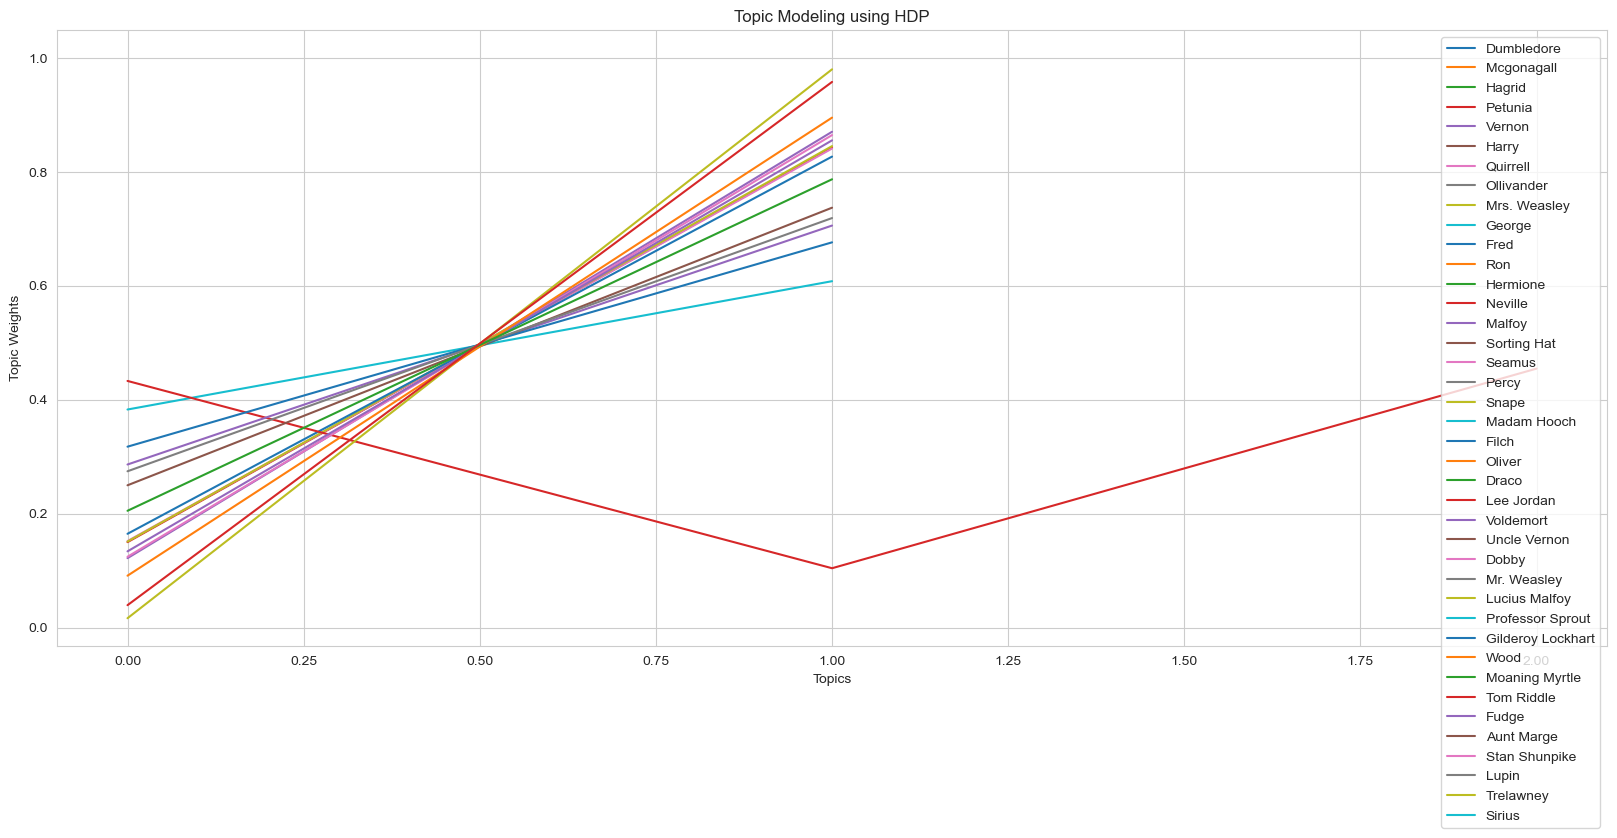

In [19]:
plt.figure(figsize=(20, 8))
sns.set_style("whitegrid")
for character, text in processed_corpus.items():
    doc_bow = dictionary.doc2bow(text)
    doc_topics = hdp_model[doc_bow]
    topic_weights = [weight for _, weight in doc_topics]

    plt.plot(range(len(topic_weights)), topic_weights, label=character)

plt.xlabel("Topics")
plt.ylabel("Topic Weights")
plt.title("Topic Modeling using HDP")
plt.legend()
plt.show()
#plt.savefig("HDP_Topics.png",dpi=300)

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 

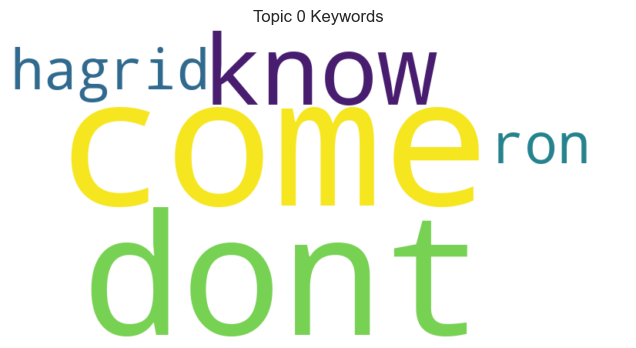

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:499: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:520: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 

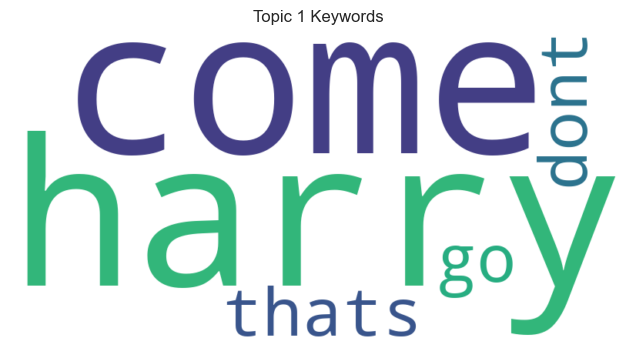

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 

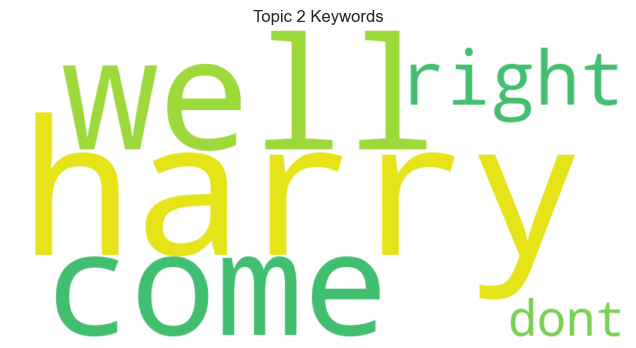

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.



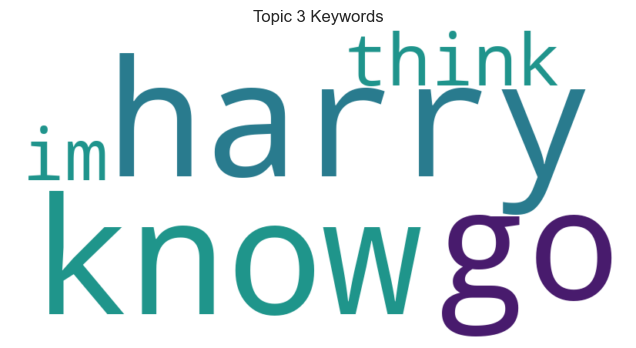

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.

E:\Anaconda3\envs\pytorch_gpu\lib\site-packages\wordcloud\wordcloud.py:519: DeprecationWarning:

ROTATE_90 is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.ROTATE_90 instead.



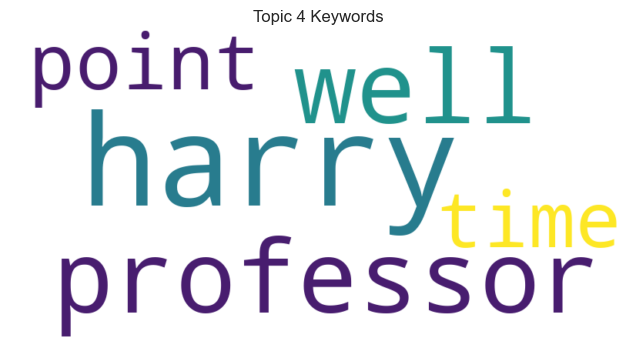

In [20]:
# Visualize word clouds for each topic
for top_num, topic in enumerate(topics):
    words_list = [item.split("*") for item in topic[1].split("+")]
    words = [word[1] for word in words_list]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))
    plt.figure(figsize=(8, 4))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Topic {} Keywords".format(top_num))
    #plt.savefig("Keywords_Cloud{}.png".format(top_num),dpi=300)
    plt.show()

# Part 4


We want to compare the different characters in terms of the characteristics of their associated corpus. For this purpose, write a script that i) calculates the size of vocabulary used by each corpus (without any preprocessing); ii) lists the words are mentioned only once in the corpus (no repetitions); iii) identify the thirty most frequent words.

In [21]:
import pandas as pd
from collections import Counter

# Group the lines by character
grouped = df.groupby('Character')

# Create a dictionary to hold the results
results = {}

# Loop over each character's lines and calculate the size of their vocabulary,
# the words that appear only once, and the thirty most frequent words.
for name, group in grouped:
    # Combine all the lines into a single string
    corp = ' '.join(group['Sentence'].tolist())
    
    # Calculate the size of the vocabulary
    words = corp.split()
    vocab_size = len(set(words))
    
    # Find the words that appear only once
    word_counts = Counter(words)
    unique_words = [word for word, count in word_counts.items() if count == 1]
    
    # Find the thirty most frequent words
    most_common = word_counts.most_common(30)
    most_common_words = [word for word, count in most_common]
    
    # Add the results to the dictionary
    results[name] = {
        'vocab_size': vocab_size,
        'unique_words': unique_words,
        'most_common': most_common_words
    }
    
    
# Print the results
for name, data in results.items():
    print(name)
    print('Vocabulary size:', data['vocab_size'])
    print('Words that appear only once:', data['unique_words'])
    print('Thirty most frequent words:', data['most_common'])
    print("################################################")


All
Vocabulary size: 2
Words that appear only once: ['AHHHHHHH!', 'YAY!']
Thirty most frequent words: ['AHHHHHHH!', 'YAY!']
################################################
All 3
Vocabulary size: 6
Words that appear only once: ['We', 'know', 'about', 'the', "Sorcerer's", 'Stone!']
Thirty most frequent words: ['We', 'know', 'about', 'the', "Sorcerer's", 'Stone!']
################################################
Aragog
Vocabulary size: 98
Words that appear only once: ['Who', 'it?', 'Hagrid?', 'Is', 'that', 'you?', 'Yes.', 'has', 'sent', 'men', 'hollow', 'before.', "That's", 'lie.', 'opened', 'Chamber', 'Secrets.', 'No.', 'monster', 'born', 'castle.', 'came', 'to', 'from', 'distant', 'land', 'pocket', 'traveler.', 'We', 'speak', 'it.', 'It', 'an', 'ancient', 'creature', 'we', 'spiders', 'fear', 'above', 'all', 'others.', 'saw', 'any', 'part', 'castle', 'but', 'box', 'which', 'kept', 'me.', 'girl', 'discovered', 'bathroom.', 'When', 'accused,', 'brought', 'me', 'here.', 'Go?', 'think', 'no

# Part 5

We want to use the result of 4) to build a similarity measure among the different characters. For this purpose, write a script that calculates the similarity between two characters as the proportion of common vocabulary between the two. Draw the corresponding character-to-character matrix.

In [22]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_similarity(character1, character2):
    # Get the two corpora
    corpus1 = df[df['Character'] == character1]['Sentence'].tolist()
    corpus2 = df[df['Character'] == character2]['Sentence'].tolist()
    
    intersection = len(list(set(corpus1).intersection(corpus2)))
    union = (len(corpus1) + len(corpus2)) - intersection
    sim_score = float(intersection) / union
    
    return sim_score

# Get a list of unique characters in the dataset
characters = df['Character'].unique()

# Create an empty dataframe to store the similarity matrix
sim_matrix = pd.DataFrame(index=characters, columns=characters)

# Loop over all pairs of characters and calculate their similarity
for i in range(len(characters)):
    for j in range(len(characters)):
        sim_score = get_similarity(characters[i], characters[j])
        sim_matrix.iloc[i,j] = sim_score
        sim_matrix.iloc[j,i] = sim_score
display(sim_matrix)

Dumbledore Mcgonagall    Hagrid   Petunia Dudley    Vernon  \
Dumbledore   0.967078   0.002564       0.0       0.0    0.0       0.0   
Mcgonagall   0.002564   0.948718       0.0       0.0    0.0  0.005263   
Hagrid            0.0        0.0  0.955335       0.0    0.0  0.002315   
Petunia           0.0        0.0       0.0  0.957447    0.0       0.0   
Dudley            0.0        0.0       0.0       0.0    1.0  0.017241   
...               ...        ...       ...       ...    ...       ...   
Goyle             0.0        0.0       0.0       0.0    0.0       0.0   
Sirius            0.0        0.0       0.0       0.0    0.0       0.0   
Pettigrew         0.0        0.0       0.0       0.0    0.0       0.0   
Boy 1             0.0        0.0       0.0       0.0    0.0       0.0   
Boy 2             0.0        0.0       0.0       0.0    0.0       0.0   

               Harry Snake Someone Barkeep Tom  Man Witch Quirrell  Boy  \
Dumbledore  0.003167   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Mcgonagall       0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Hagrid      0.005658   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Petunia     0.000932   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Dudley      0.001912   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
...              ...   ...     ...         ...  ...   ...      ...  ...   
Goyle            0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Sirius           0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Pettigrew        0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Boy 1            0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   
Boy 2            0.0   0.0     0.0         0.0  0.0   0.0      0.0  0.0   

              Goblin Griphook Ollivander Trainmaster Mrs. Weasley George  \
Dumbledore       0.0      0.0        0.0         0.0          0.0    0.0   
Mcgonagall  0.006536      0.0        0.0         0.0          0.0    0.0   
Hagrid           0.0      0.0        0.0         0.0     0.006438    0.0   
Petunia          0.0      0.0        0.0         0.0          0.0    0.0   
Dudley           0.0      0.0        0.0         0.0          0.0    0.0   
...              ...      ...        ...         ...          ...    ...   
Goyle            0.0      0.0        0.0         0.0          0.0    0.0   
Sirius           0.0      0.0        0.0         0.0          0.0    0.0   
Pettigrew        0.0      0.0        0.0         0.0          0.0    0.0   
Boy 1            0.0      0.0        0.0         0.0          0.0    0.0   
Boy 2            0.0      0.0        0.0         0.0          0.0    0.0   

               Fred     Ginny       Ron Woman  Hermione Neville    Malfoy  \
Dumbledore      0.0  0.004065  0.002587   0.0  0.004161     0.0       0.0   
Mcgonagall      0.0       0.0       0.0   0.0       0.0     0.0  0.005348   
Hagrid      0.00464       0.0  0.003236   0.0  0.003425     0.0       0.0   
Petunia         0.0       0.0       0.0   0.0       0.0     0.0       0.0   
Dudley          0.0       0.0       0.0   0.0       0.0     0.0       0.0   
...             ...       ...       ...   ...       ...     ...       ...   
Goyle           0.0       0.0       0.0   0.0       0.0     0.0       0.0   
Sirius          0.0       0.0       0.0   0.0       0.0     0.0       0.0   
Pettigrew       0.0       0.0       0.0   0.0       0.0     0.0       0.0   
Boy 1           0.0       0.0       0.0   0.0       0.0     0.0       0.0   
Boy 2           0.0       0.0       0.0   0.0       0.0     0.0       0.0   

           Whispers Sorting Hat    Seamus Percy Sir Nicholas Girl  \
Dumbledore      0.0         0.0  0.003717   0.0     0.007968  0.0   
Mcgonagall      0.0         0.0       0.0   0.0     0.006061  0.0   
Hagrid          0.0         0.0       0.0   0.0          0.0  0.0   
Petunia         0.0         0.0       0.0   0.0          0.0  0.0   
Dudley          0.0         0.0       0.0   0.0   

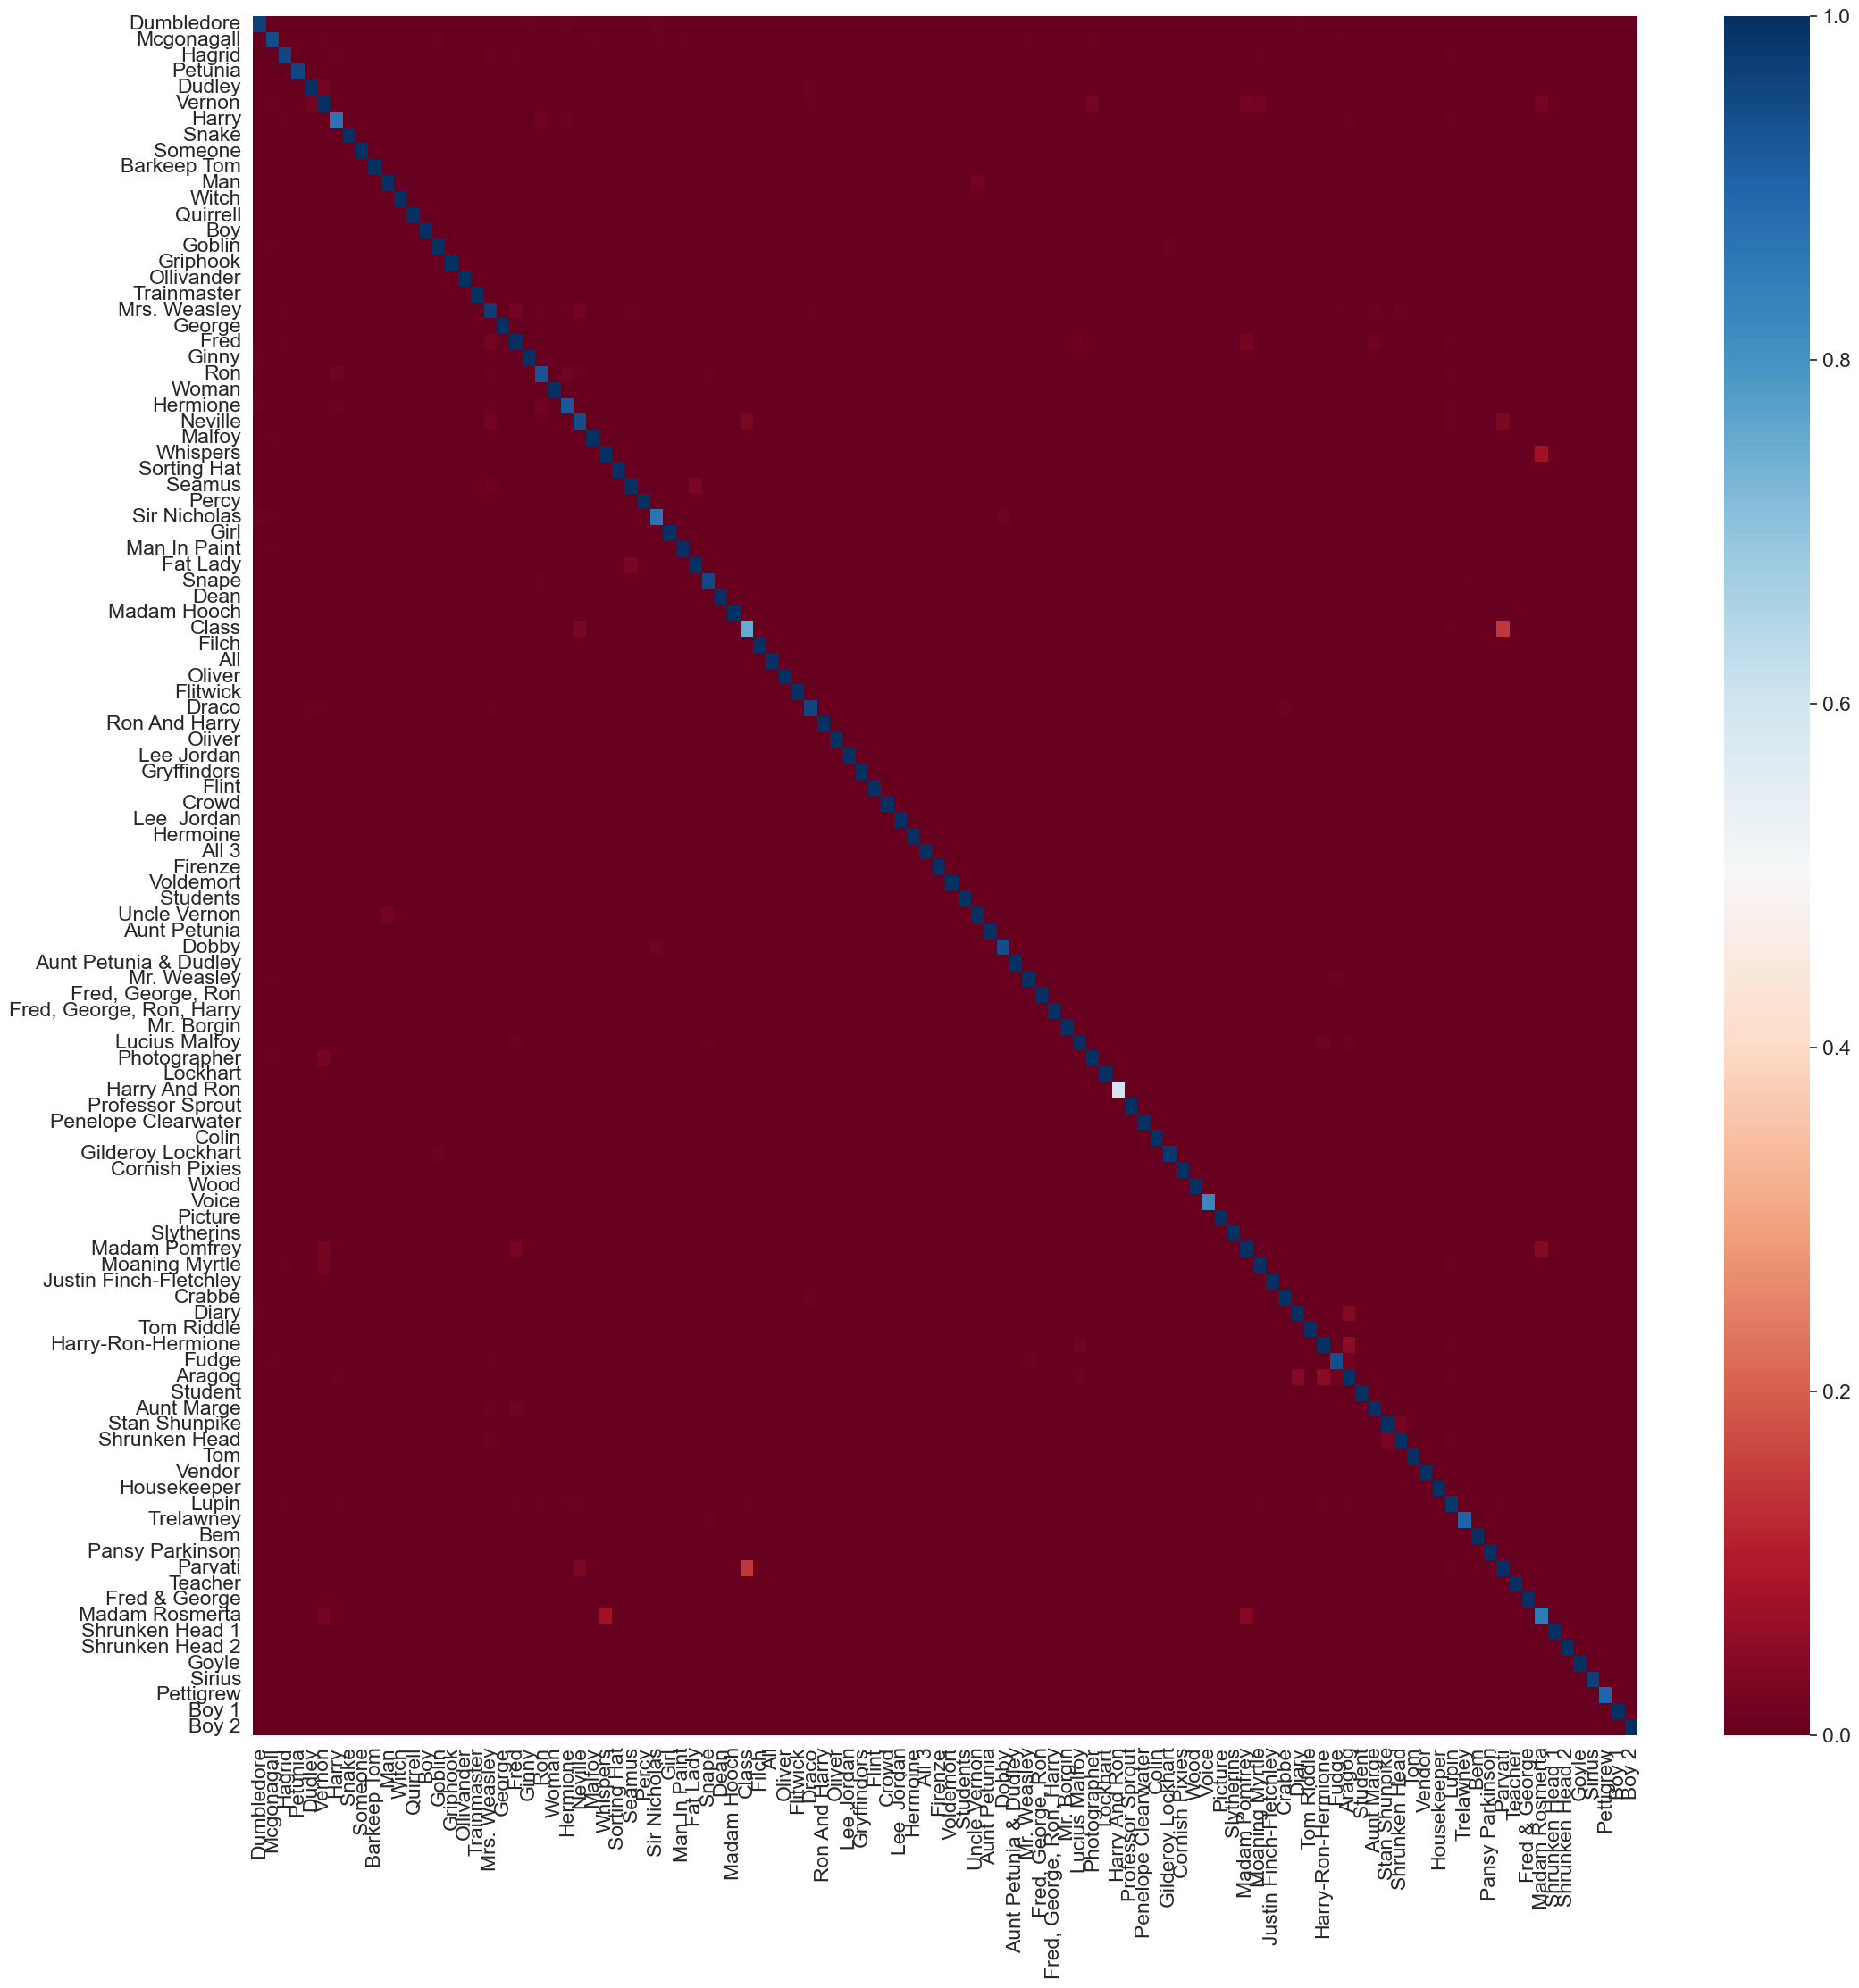

In [23]:
sim_matrix = sim_matrix.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    sim_matrix,
    cmap='RdBu',xticklabels=sim_matrix.columns,yticklabels=sim_matrix.columns,
)
#plt.savefig("sim_mat_5.png")

# Part 6

Repeat 5) when the similarity is understood as the proportion of unique words in the corpus of both characters (words that have no repetition in the corpus).

In [24]:
# Define function to calculate similarity between two characters
def calc_similarity(char1, char2):
    # Get the scripts of the two characters
    char1_script = df[df.Character == char1]['Sentence'].tolist()
    char2_script = df[df.Character == char2]['Sentence'].tolist()

    # Concatenate the scripts and split into words
    words = ' '.join(char1_script + char2_script).split()

    # Count the number of occurrences of each word
    word_counts = Counter(words)
    # Count the number of unique words
    unique_word_counts = Counter(word_counts.values())[1]

    # Calculate the proportion of unique words
    total_words = len(words)
    prop_unique_words = unique_word_counts / total_words

    return prop_unique_words

# Get a list of unique characters in the dataset
characters = df['Character'].unique()

# Create an empty dataframe to store the similarity matrix
sim_matrix = pd.DataFrame(index=characters, columns=characters)

# Loop over all pairs of characters and calculate their similarity
for i in range(len(characters)):
    for j in range(len(characters)):
        sim_score = calc_similarity(characters[i], characters[j])
        sim_matrix.iloc[i,j] = sim_score
        sim_matrix.iloc[j,i] = sim_score
display(sim_matrix)


Dumbledore Mcgonagall    Hagrid   Petunia    Dudley    Vernon  \
Dumbledore        0.0   0.281437  0.249838  0.328739  0.346417  0.342956   
Mcgonagall   0.281437        0.0  0.260397  0.338794    0.3613  0.357192   
Hagrid       0.249838   0.260397       0.0  0.281372   0.29246   0.28701   
Petunia      0.328739   0.338794  0.281372       0.0  0.501326  0.485207   
Dudley       0.346417     0.3613   0.29246  0.501326       0.0  0.598684   
...               ...        ...       ...       ...       ...       ...   
Goyle        0.339953   0.360866  0.289804   0.51495  0.785714  0.662281   
Sirius       0.322655   0.329077  0.270985  0.406692  0.489547  0.440341   
Pettigrew     0.33544   0.358575  0.288679  0.493766  0.681818  0.582317   
Boy 1        0.340769   0.359161  0.290716  0.501706  0.811111  0.640909   
Boy 2         0.33982   0.357546  0.291503  0.505119  0.811111  0.659091   

               Harry     Snake   Someone Barkeep Tom       Man     Witch  \
Dumbledore  0.209583  0.340143  0.340143    0.340737  0.342414   0.33957   
Mcgonagall  0.207202  0.358124  0.358124    0.358974  0.361618  0.358268   
Hagrid       0.19188  0.291339  0.291339    0.291258  0.292512  0.291489   
Petunia     0.210546  0.501718  0.501718    0.503311  0.514286       0.5   
Dudley       0.21474  0.806818  0.806818    0.818182    0.8125  0.735537   
...              ...       ...       ...         ...       ...       ...   
Goyle       0.215586       1.0       1.0         1.0  0.888889  0.866667   
Sirius      0.211177   0.47541   0.47541     0.47495  0.478516  0.456814   
Pettigrew   0.215671  0.669643  0.669643    0.666667  0.698529  0.668966   
Boy 1       0.215729       1.0       1.0         1.0  0.785714  0.918919   
Boy 2       0.215532       1.0       1.0         1.0  0.857143  0.918919   

            Quirrell       Boy    Goblin  Griphook Ollivander Trainmaster  \
Dumbledore  0.335625  0.339552  0.337748  0.340587   0.332291    0.341337   
Mcgonagall  0.355723  0.362069  0.353933  0.358748   0.350109    0.356688   
Hagrid      0.287835  0.291974  0.289918  0.291487   0.286088    0.290739   
Petunia     0.469786  0.506061  0.506667  0.503333   0.470588    0.503226   
Dudley      0.603226  0.748031  0.824742  0.783505   0.648649    0.785047   
...              ...       ...       ...       ...        ...         ...   
Goyle       0.615385  0.803922       1.0  0.809524   0.636986    0.806452   
Sirius      0.460563  0.478178  0.476861  0.476861    0.44373    0.473373   
Pettigrew    0.57485  0.629139   0.68595  0.661157   0.577236    0.664122   
Boy 1       0.615044  0.767442       1.0  0.692308   0.623188    0.826087   
Boy 2       0.615044  0.813953       1.0  0.692308   0.623188    0.826087   

           Mrs. Weasley    George      Fred     Ginny       Ron     Woman  \
Dumbledore     0.336771  0.337719  0.344479  0.338008  0.268597  0.339972   
Mcgonagall     0.343618  0.358357  0.356584  0.358773  0.278986  0.359388   
Hagrid         0.286874   0.28582  0.292467  0.291375  0.239985  0.290881   
Petunia        0.442716  0.491416  0.511983  0.513846  0.293694  0.498305   
Dudley         0.519841   0.65019  0.652344  0.778689  0.305341  0.804348   
...                 ...       ...       ...       ...       ...       ...   
Goyle          0.518692  0.673797  0.683333  0.869565  0.306177       1.0   
Sirius          0.43031  0.466063  0.481707  0.475096  0.293419  0.473577   
Pettigrew           0.5  0.585366     0.625  0.650685  0.303395  0.655172   
Boy 1          0.514286  0.687151  0.680233  0.894737  0.305207       1.0   
Boy 2          0.519048  0.675978  0.680233  0.894737  0.304827       1.0   

            Hermione   Neville    Malfoy  Whispers Sorting Hat    Seamus  \
Dumbledore  0.259848  0.336995  0.339262  0.339981    0.334083  0.342704   
Mcgonagall  0.267774  0.359375  0.353514  0.357835     0.35472  0.368536   
Hagrid      0.242389  0.288086  0.287591  0.290437    0.288454  0.296338   
Petunia     0.295736  0.471861 

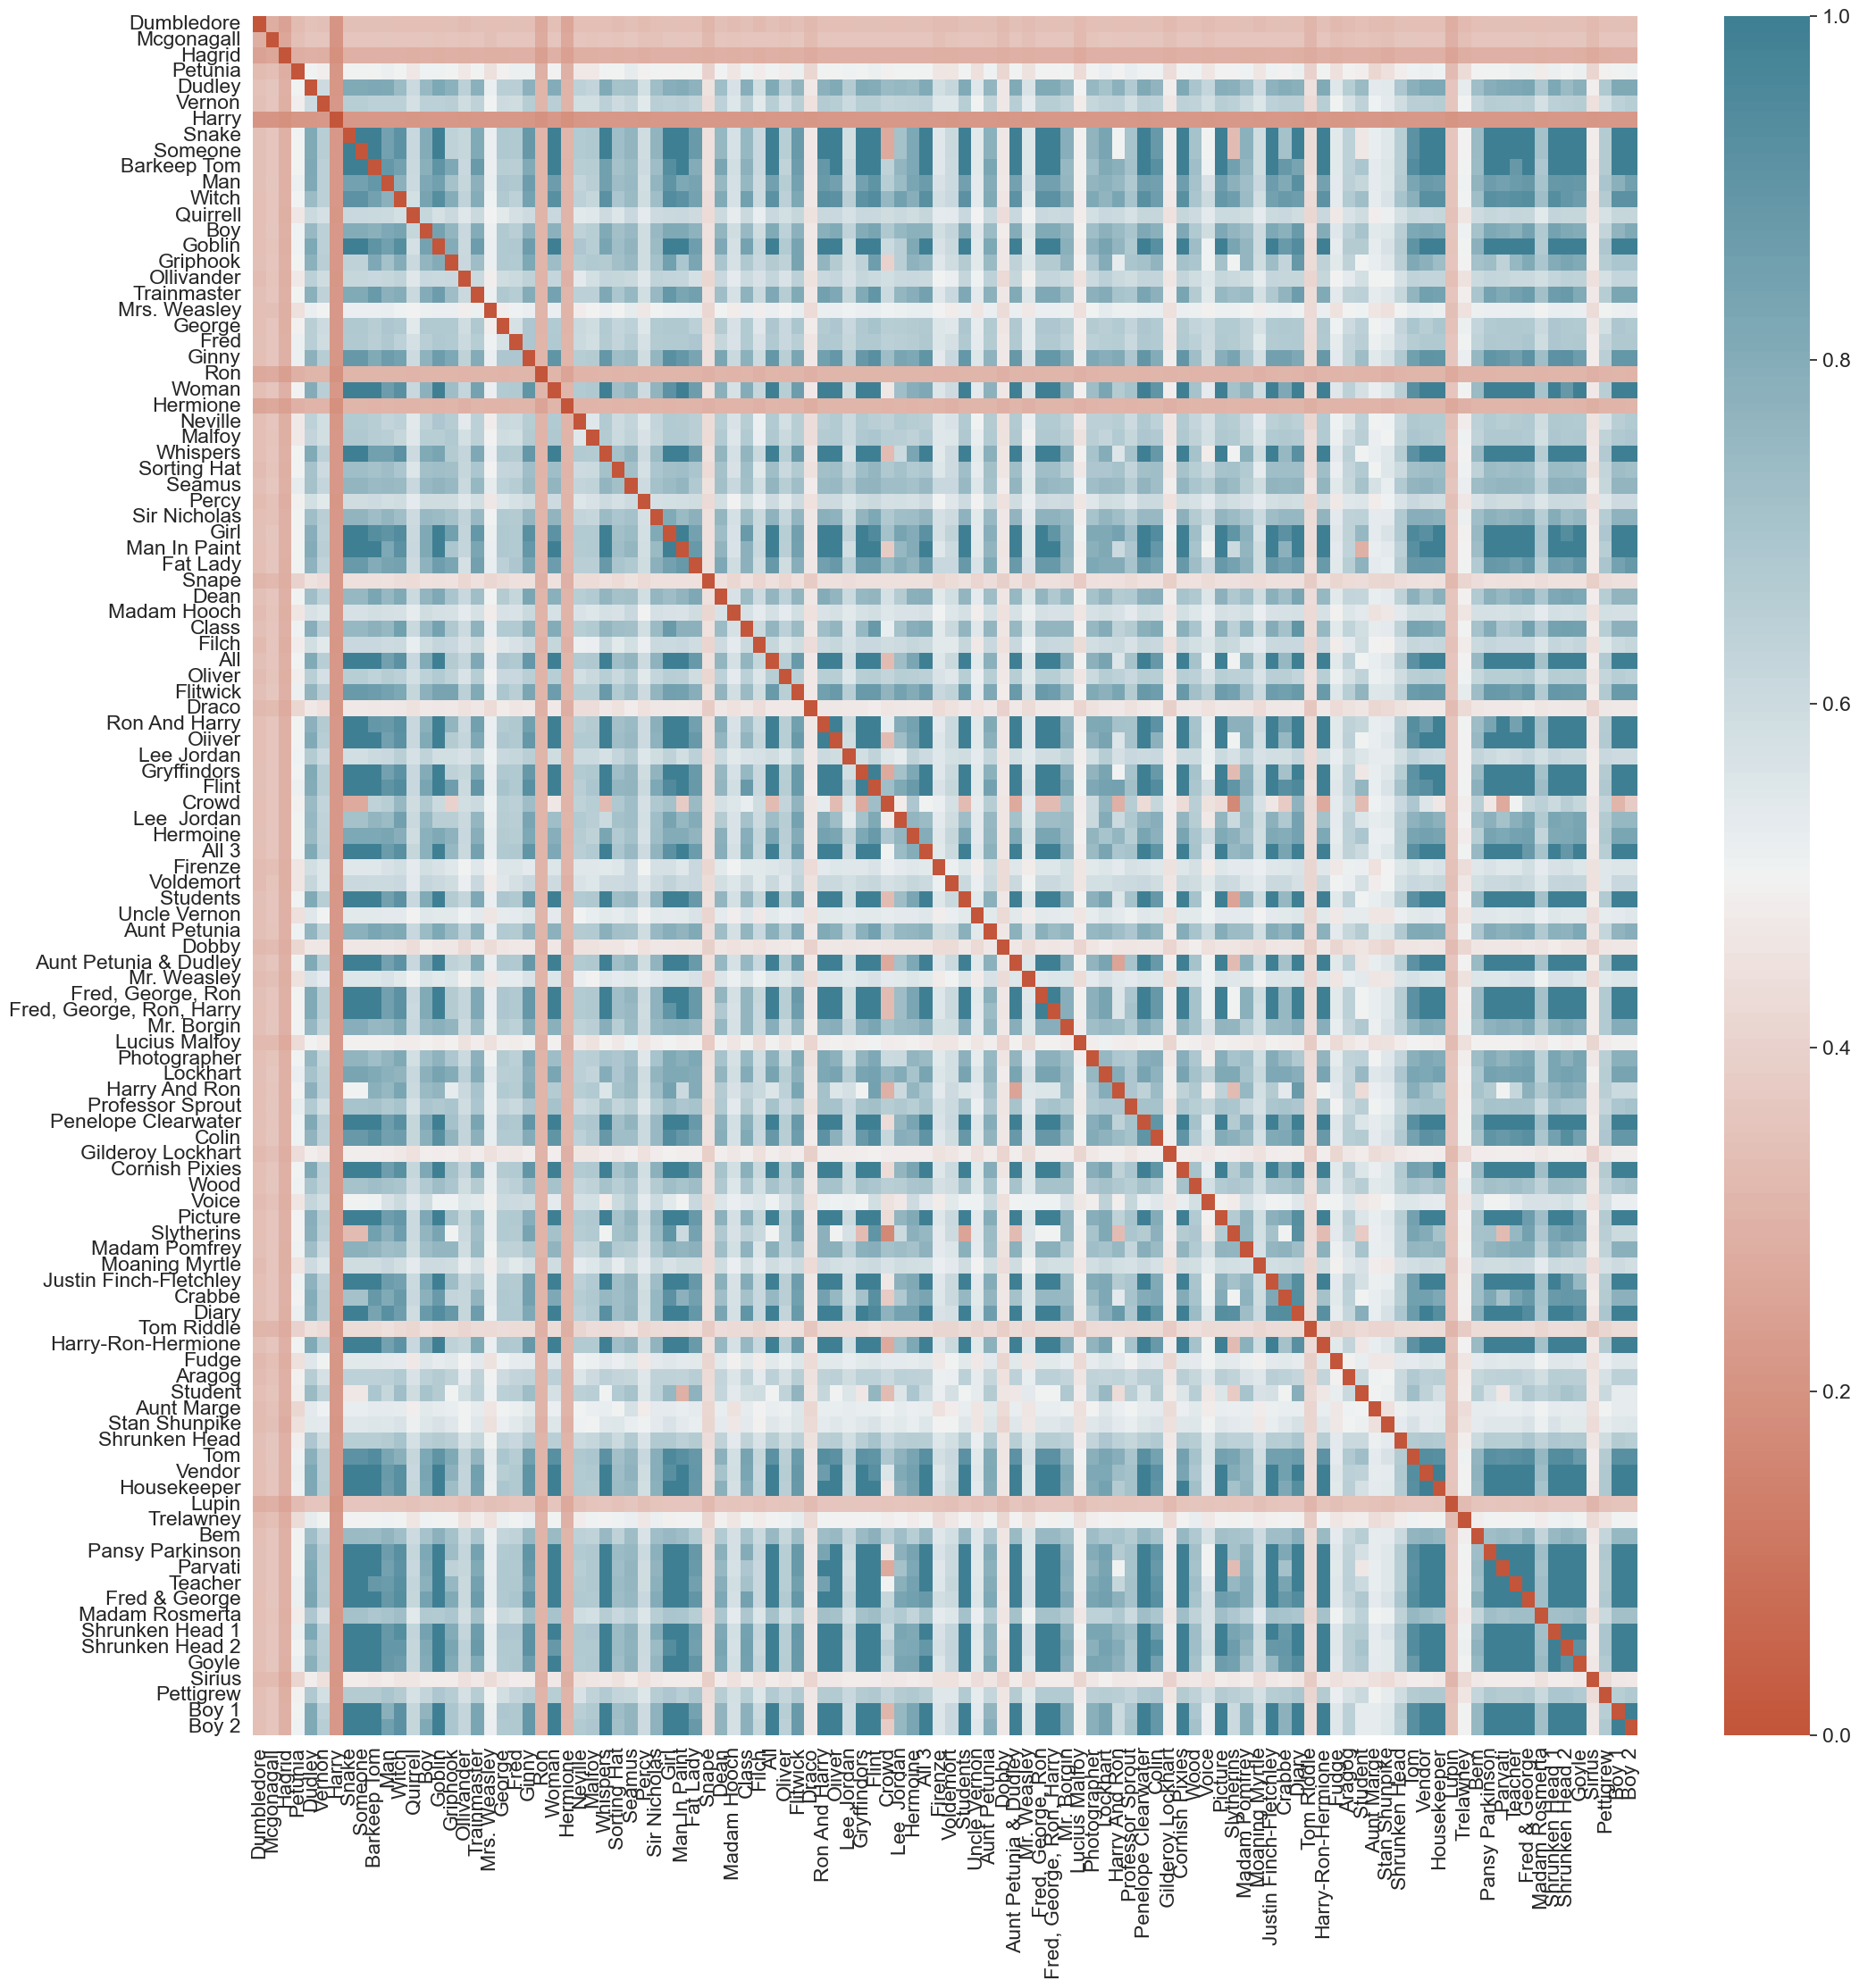

In [25]:
sim_matrix = sim_matrix.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    sim_matrix,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=sim_matrix.columns,yticklabels=sim_matrix.columns,
)
#plt.savefig("sim_mat_6.png")

# Part 7

Construct a global vocabulary by integrating the vocabulary of each character. Write a script using tf-idf vectorizer of Gensim to provide a vector representation of each corpus and then use the cosine similarity to calculate the similarity between two characters. Write down the new similarity matrix.

In [26]:
import pandas as pd
import numpy as np
from gensim.models import TfidfModel
from gensim.corpora import Dictionary
from sklearn.metrics.pairwise import cosine_similarity


# Create a dictionary for each character's script
characters = df.Character.unique()
char_scripts = {}
for char in characters:
    char_scripts[char] = df[df.Character == char]['Sentence'].tolist()

# Create a global vocabulary by integrating the vocabulary of each character
dictionary = Dictionary(char_scripts.values())
corpus_global = [dictionary.doc2bow(text) for text in char_scripts.values()]

# Create a tf-idf model for the corpus
tfidf = TfidfModel(corpus_global)

# Create a vector representation of each corpus using tf-idf
char_vectors = {}
for char, script in char_scripts.items():
    char_corpus = dictionary.doc2bow(script)
    char_tfidf = tfidf[char_corpus]
    char_vector = np.zeros(len(dictionary))
    for idx, val in char_tfidf:
        char_vector[idx] = val
    char_vectors[char] = char_vector

# Calculate the similarity between two characters using cosine similarity
similarity_matrix = np.zeros((len(characters), len(characters)))
for i in range(len(characters)):
    for j in range(i, len(characters)):
        char1 = characters[i]
        char2 = characters[j]
        similarity = cosine_similarity([char_vectors[char1]], [char_vectors[char2]])[0][0]
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

# Write down the new similarity matrix
similarity_df = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
pd.set_option('display.max_rows', None)
display(similarity_df)


Dumbledore  Mcgonagall    Hagrid   Petunia  \
Dumbledore                  1.000000    0.003010  0.000000  0.000000   
Mcgonagall                  0.003010    1.000000  0.000000  0.000000   
Hagrid                      0.000000    0.000000  1.000000  0.000000   
Petunia                     0.000000    0.000000  0.000000  1.000000   
Dudley                      0.000000    0.000000  0.000000  0.000000   
Vernon                      0.000000    0.007656  0.004785  0.000000   
Harry                       0.025156    0.000000  0.014283  0.003093   
Snake                       0.000000    0.000000  0.000000  0.000000   
Someone                     0.000000    0.000000  0.000000  0.000000   
Barkeep Tom                 0.000000    0.000000  0.000000  0.000000   
Man                         0.000000    0.000000  0.000000  0.000000   
Witch                       0.000000    0.000000  0.000000  0.000000   
Quirrell                    0.000000    0.000000  0.000000  0.000000   
Boy                         0.000000    0.000000  0.000000  0.000000   
Goblin                      0.000000    0.037063  0.000000  0.000000   
Griphook                    0.000000    0.000000  0.000000  0.000000   
Ollivander                  0.000000    0.000000  0.000000  0.000000   
Trainmaster                 0.000000    0.000000  0.000000  0.000000   
Mrs. Weasley                0.000000    0.000000  0.007843  0.000000   
George                      0.000000    0.000000  0.000000  0.000000   
Fred                        0.000000    0.000000  0.006838  0.000000   
Ginny                       0.016839    0.000000  0.000000  0.000000   
Ron                         0.002794    0.000000  0.005421  0.000000   
Woman                       0.000000    0.000000  0.000000  0.000000   
Hermione                    0.005218    0.000000  0.003848  0.000000   
Neville                     0.000000    0.000000  0.000000  0.000000   
Malfoy                      0.000000    0.009676  0.000000  0.000000   
Whispers                    0.000000    0.000000  0.000000  0.000000   
Sorting Hat                 0.000000    0.000000  0.000000  0.000000   
Seamus                      0.005148    0.000000  0.000000  0.000000   
Percy                       0.000000    0.000000  0.000000  0.000000   
Sir Nicholas                0.071554    0.012631  0.000000  0.000000   
Girl                        0.000000    0.000000  0.000000  0.000000   
Man In Paint                0.000000    0.067881  0.000000  0.000000   
Fat Lady                    0.000000    0.000000  0.000000  0.000000   
Snape                       0.000000    0.005203  0.000000  0.000000   
Dean                        0.000000    0.000000  0.000000  0.000000   
Madam Hooch                 0.000000    0.000000  0.000000  0.000000   
Class                       0.000000    0.000000  0.000000  0.000000   
Filch                       0.000000    0.000000  0.000000  0.000000   
All                         0.000000    0.000000  0.000000  0.000000   
Oliver                      0.000000    0.000000  0.000000  0.000000   
Flitwick                    0.000000    0.000000  0.000000  0.000000   
Draco                       0.000000    0.000000  0.008899  0.000000   
Ron And Harry               0.000000    0.000000  0.000000  0.000000   
Oiiver                      0.000000    0.000000  0.000000  0.000000   
Lee Jordan                  0.000000    0.000000  0.000000  0.000000   
Gryffindors                 0.000000    0.000000  0.000000  0.000000   
Flint                       0.000000    0.000000  0.000000  0.000000   
Crowd                       0.000000    0.000000  0.000000  0.000000   
Lee  Jordan                 0.000000    0.000000  0.000000  0.000000   
Hermoine                    0.000000    0.000000  0.000000  0.000000   
All 3                       0.000000    0.000000  0.000000  0.000000   
Firenze                     0.000000    0.000000  0.000000  0.000000   
Voldemort                   0.000000    0.000000  0.000000  0.0000

<AxesSubplot: >

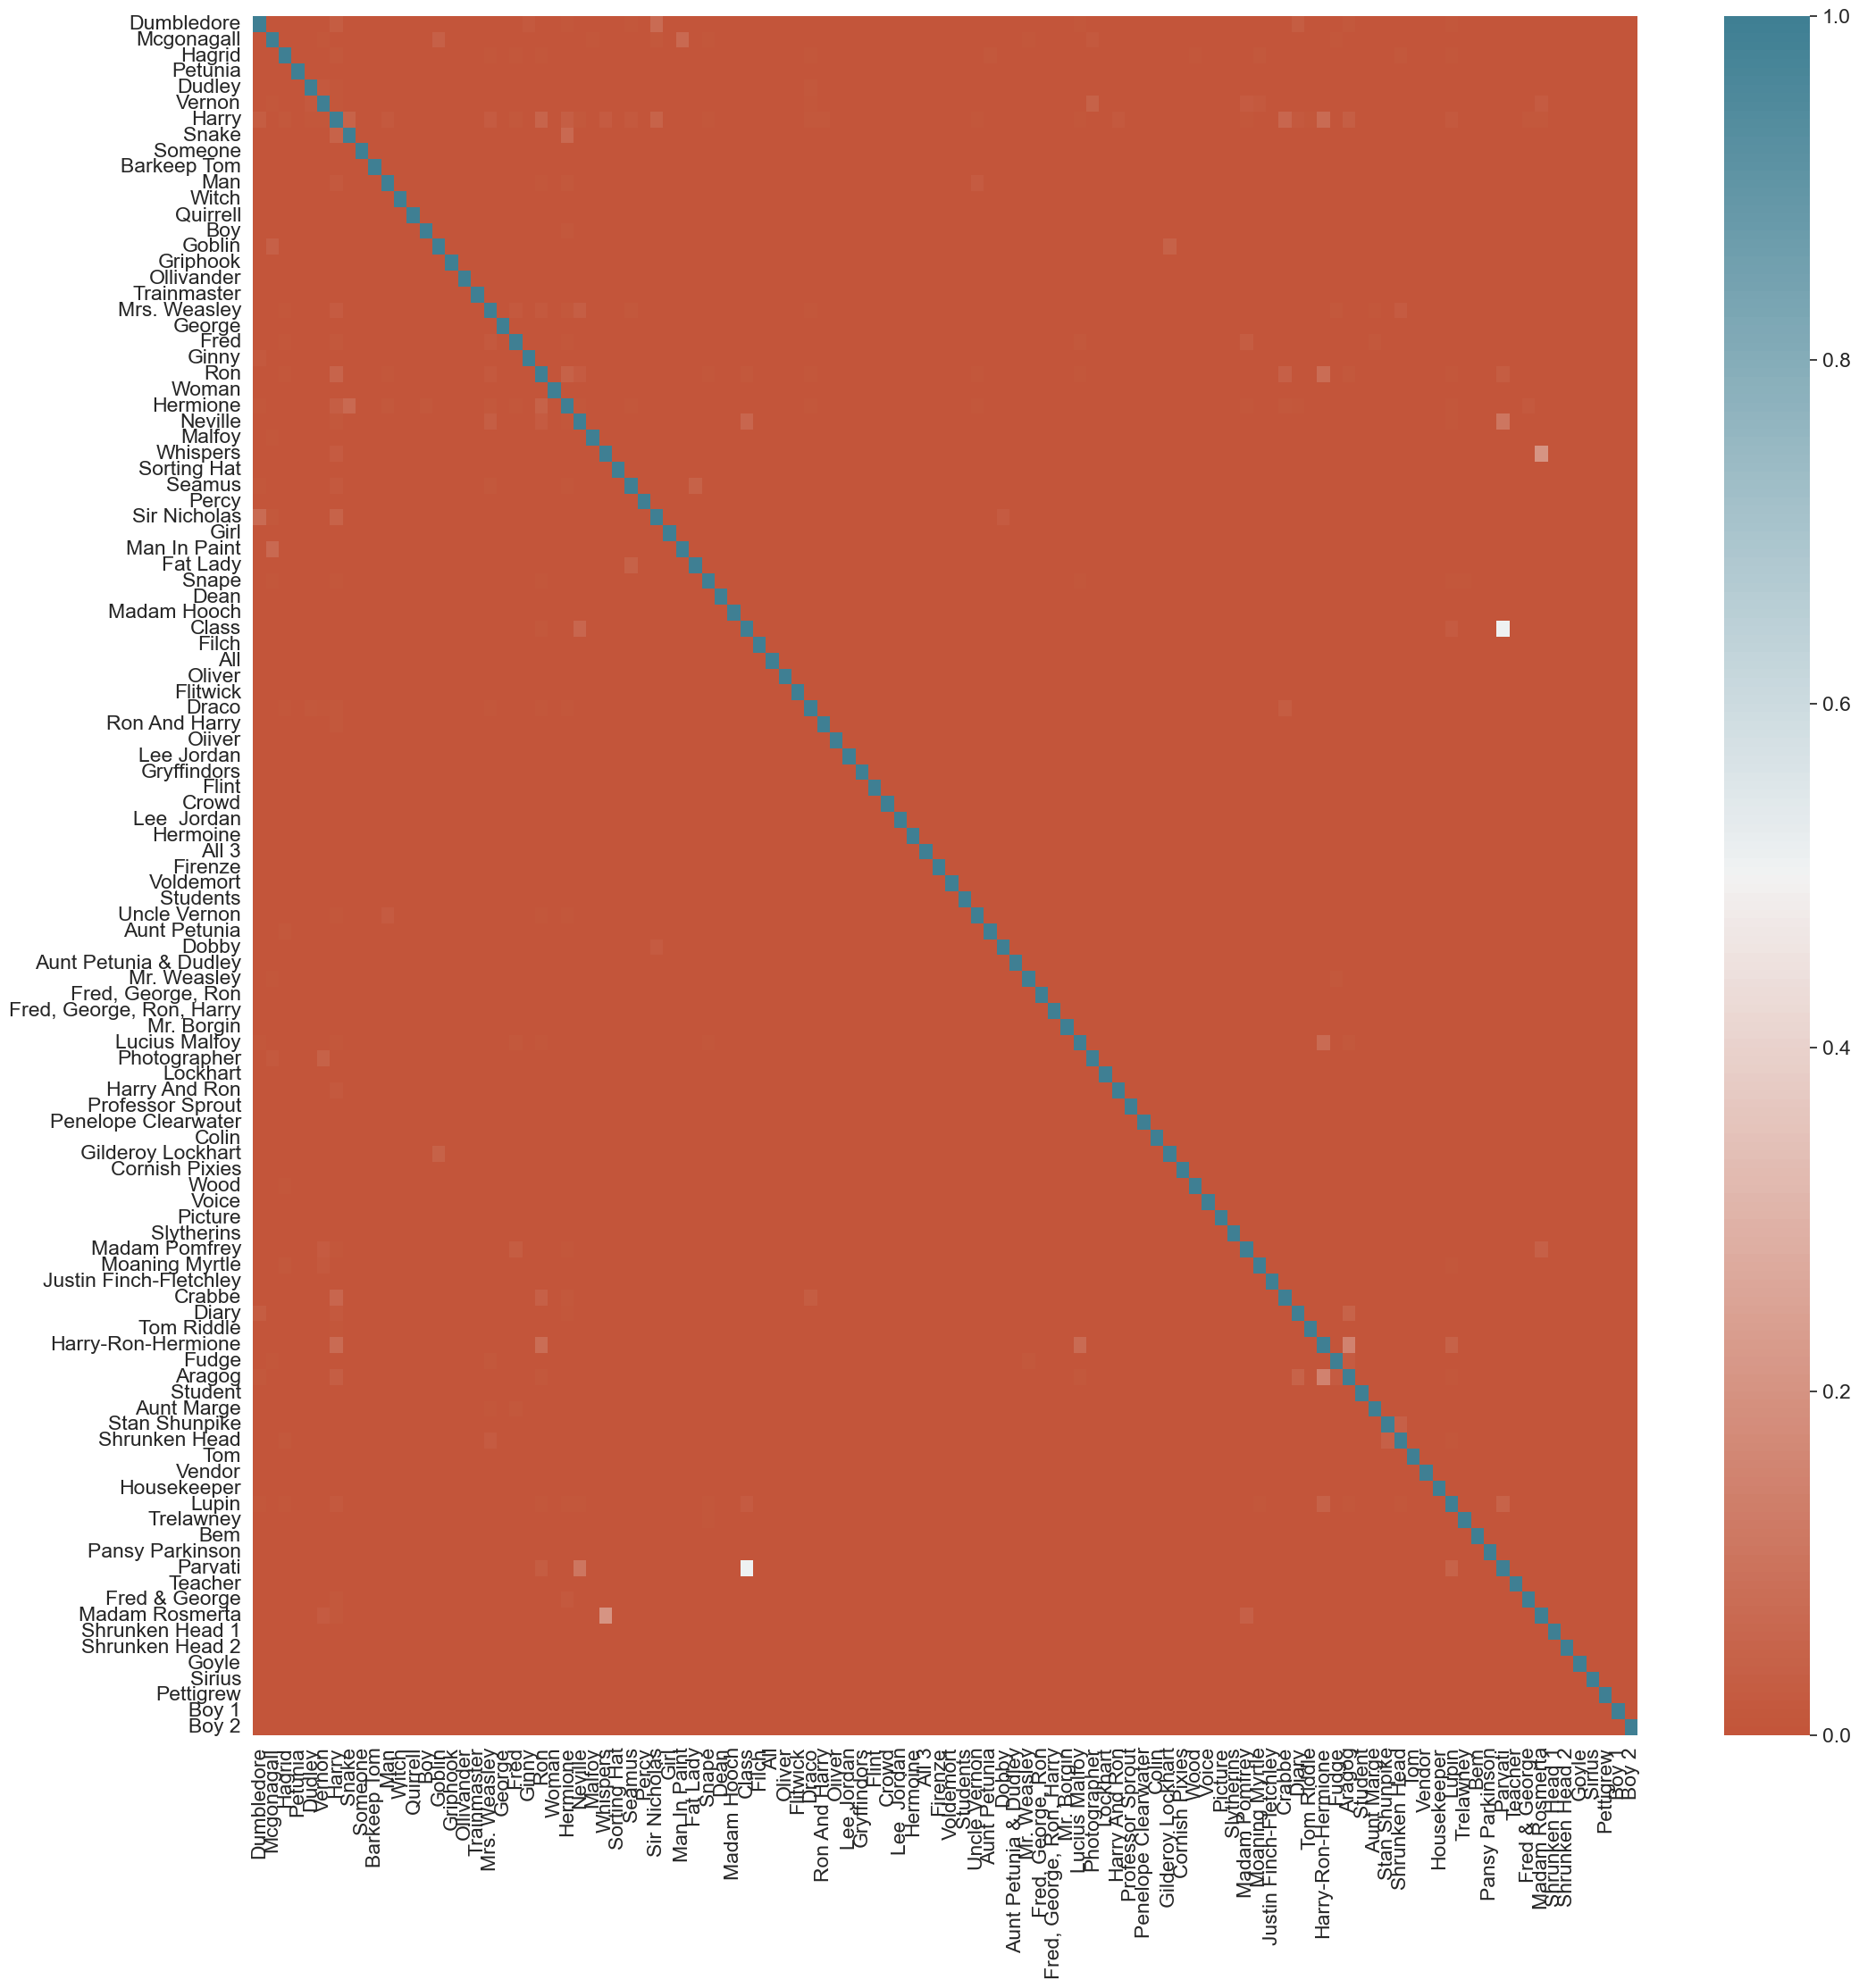

In [27]:
similarity_df = similarity_df.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_df,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_df.columns,yticklabels=similarity_df.columns,
)
#plt.savefig("sim_mat_7.png")

# Part 8

Use SentiWordnet (see link at previous projects), to calculate the sentiment score (positive and negative sentiment score) of each individual script of each character. Represent in a 2D space (x-axis corresponds to positive sentiment score and y-axis for negative sentiment score the sentiment of each individual script as a dot in this graph (you may use same color to represent the same character).

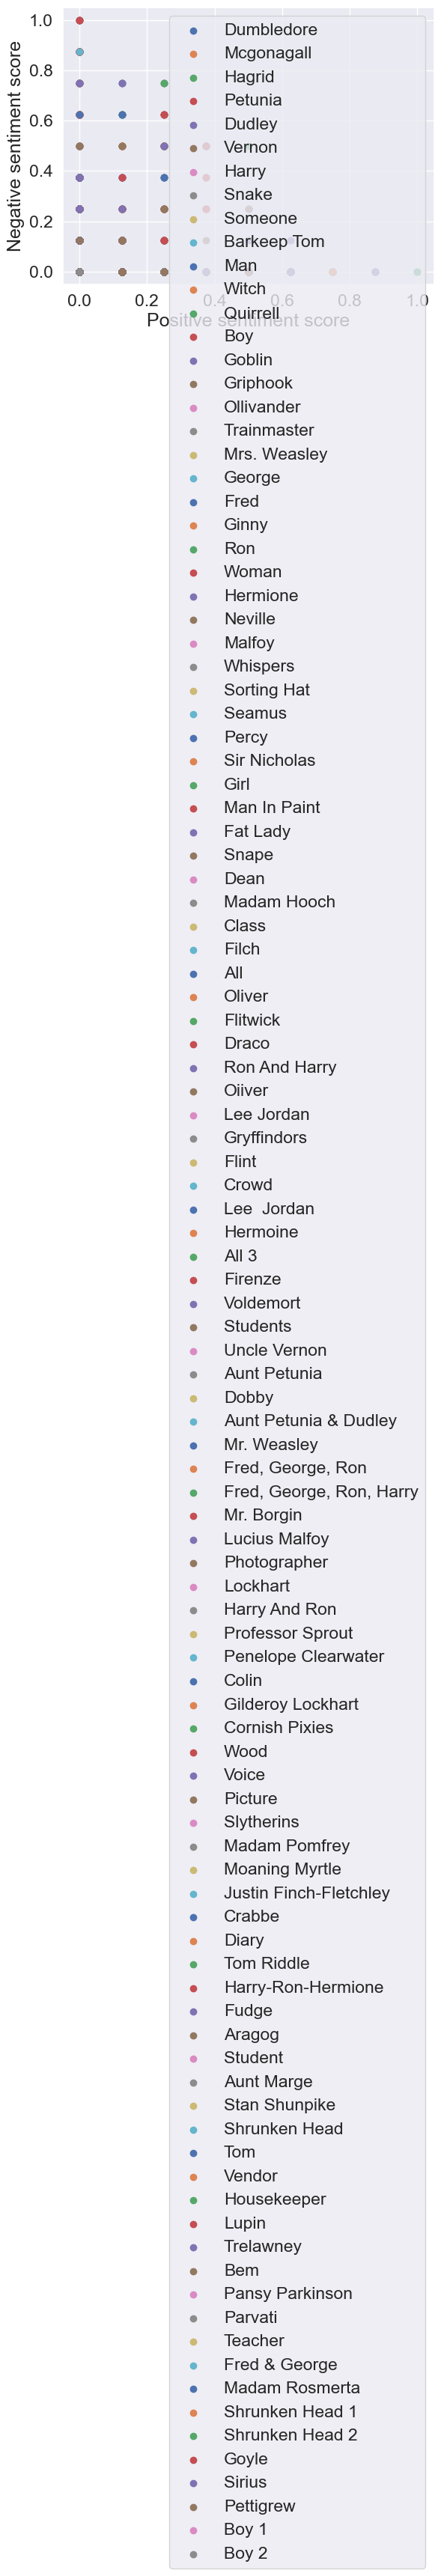

In [30]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import matplotlib.pyplot as plt

def get_sentiment_score(text):
    tokens = nltk.word_tokenize(text.lower())
    lemmas = [nltk.WordNetLemmatizer().lemmatize(token) for token in tokens]
    pos_tags = nltk.pos_tag(lemmas)
    pos_scores = []
    neg_scores = []
    for token, pos in pos_tags:
        synsets = wn.synsets(token, pos=wn.NOUN)
        if synsets:
            synset = synsets[0]
            senti_synset = swn.senti_synset(synset.name())
            pos_scores.append(senti_synset.pos_score())
            neg_scores.append(senti_synset.neg_score())
            
    if pos_scores and neg_scores:
        pos_score = sum(pos_scores) / len(pos_scores)
        neg_score = sum(neg_scores) / len(neg_scores)
        return pos_score, neg_score
    else:
        return None

for character, lines in corpus.items():
    x = []
    y = []
    for line in lines:
        scores = get_sentiment_score(line)
        if scores:
            x.append(scores[0])
            y.append(scores[1])
    plt.scatter(x, y, label=character)
plt.xlabel('Positive sentiment score')
plt.ylabel('Negative sentiment score')
plt.legend(corpus.keys(),loc="best")
plt.show()


# Part 9

Use pretrained word2vec model available in Gensim to represent each character’s script. Use the average operation to infer the word2vec embedding of every corpus. Then use cosine similarity to calculate the similarity of every pair of characters. Draw a matrix showing the similarity among the various characters.

In [ ]:
import gensim

model = gensim.models.KeyedVectors.load_word2vec_format("C:/Users/umers/gensim-data/word2vec-google-news-300/GoogleNews-vectors-negative300.bin", binary=True)

In [ ]:
import gensim
import numpy as np

# Define a function to convert each script to a Word2Vec embedding
def get_embedding(script):
    words = script.split()
    embedding = np.zeros((model.vector_size,))
    count = 0
    for word in words:
        if word in model:
            embedding += model[word]
            count += 1
    if count > 0:
        embedding /= count
    return embedding

# Calculate the average Word2Vec embedding for each character's script
character_embeddings = []
for character in characters:
    embedding = get_embedding(" ".join(corpus[character]))
    character_embeddings.append(embedding)

# Calculate the similarity between each pair of characters
similarity_matrix = np.zeros((len(characters), len(characters)))
for i in range(len(characters)):
    for j in range(i, len(characters)):
        similarity = np.dot(character_embeddings[i], character_embeddings[j]) / (np.linalg.norm(character_embeddings[i]) * np.linalg.norm(character_embeddings[j]))
        similarity_matrix[i][j] = similarity
        similarity_matrix[j][i] = similarity

# Print the similarity matrix
similarity_mat_df = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
display(similarity_mat_df)



In [ ]:
similarity_mat_df = similarity_mat_df.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_mat_df,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_mat_df.columns,yticklabels=similarity_mat_df.columns,
)
plt.savefig("sim_mat_9.png")

# Part 10

We want to use Word2vec model trained on historical corpus. Consider the histwords, available at HistWords: Word Embeddings for Historical Text (stanford.edu).  Repeat 5) when you use the historical word2vec embedding. 

In [ ]:
import pickle

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import OrderedDict
from gensim.models import KeyedVectors
from gensim.matutils import unitvec
from whatlies import EmbeddingSet, Embedding
from whatlies.transformers import Normalizer, Tsne
from sklearn.manifold import TSNE
import gensim
import numpy as np

In [ ]:
# load histwords as gensim KeyedVectors
dic_plot = {}

for yr in [1800,1810,1820,1830,1840,1850,1870,1880,1890,1900]:
    def load_historical_embeddings(year, path="./historical_model/sgns/"):
        with open(path + str(year) + "-vocab.pkl", "rb") as f:
            vocab = pickle.load(f)
            vectors = np.load(path + str(year) + "-w.npy", mmap_mode="c")


        kv = KeyedVectors(vector_size=vectors.shape[1])

        kv.add(entities=vocab, weights=vectors)

        return kv

    emb_hist = OrderedDict()
    emb_hist[yr] = load_historical_embeddings(yr)

    # Define a function to convert each script to a Word2Vec embedding
    def get_embedding(script):
        words = script.split()
        embedding = np.zeros((emb_hist[yr].vector_size,))
        count = 0
        for word in words:
            if word in emb_hist[yr]:
                embedding += emb_hist[yr][word]
                count += 1
        if count > 0:
            embedding /= count
        return embedding

    # Calculate the average Word2Vec embedding for each character's script
    character_embeddings = []
    for character in characters:
        embedding = get_embedding(" ".join(corpus[character]))
        character_embeddings.append(embedding)

    # Calculate the similarity between each pair of characters
    similarity_matrix = np.zeros((len(characters), len(characters)))
    for i in range(len(characters)):
        for j in range(i, len(characters)):
            similarity = np.dot(character_embeddings[i], character_embeddings[j]) / (np.linalg.norm(character_embeddings[i]) * np.linalg.norm(character_embeddings[j]))
            similarity_matrix[i][j] = similarity
            similarity_matrix[j][i] = similarity

    # Print the similarity matrix
    similarity_mat_df1 = pd.DataFrame(similarity_matrix, index=characters, columns=characters)
    dic_plot[yr] = similarity_mat_df1.loc["Dumbledore","Harry"]
    #display(similarity_mat_df1)
print(dic_plot)

In [ ]:
hag_har = 1800,0.969633,1810,0.956776
dum_har = 1800,0.931503,1810,

In [ ]:
similarity_mat_df1 = similarity_mat_df1.astype(float)
plt.figure(figsize=(25,25))
sns.set(font_scale=1.5)
sns.heatmap(
    similarity_mat_df1,
    cmap=sns.diverging_palette(20, 220, n=200),xticklabels=similarity_mat_df1.columns,yticklabels=similarity_mat_df1.columns,
)
plt.savefig("sim_mat_10.png")